# Superorbital (Lack of) Periodicity
- look into periods reported in Rajoelimanana et al. 2011
- remake figure about changing superorbital period of SXP 6.85 = similar to LXP 69.5

In [1]:
from uncertainties import ufloat
from uncertainties.umath import *
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.stats import LombScargle
from scipy import signal
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import scipy.optimize
import glob
from astropy.table import Table,join,vstack,unique
from importlib import reload
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sb
import scipy.stats as st
import wotan

import ogle as o #module

blue = 'cornflowerblue'
navy = 'navy'
purple = 'rebeccapurple'
pink = '#CF6275'
maroon = 'maroon'

cross = Table.read('sourcefiles.csv')
full = Table.read('smc_x_m03_zar_match_OGLE_v2.ascii',format='ascii')

summ = pd.read_csv('Feb23_summtab.csv')
alls = pd.read_csv('current_summ.csv') #most updated table from before Feb23 restart

phase = pd.read_csv('Feb23_phasetab.csv')
cross2 = Table.read('part2files.csv')
cross2 = join(cross2,full,keys='src_n')
mlist2 = ['OII I','OIII I','OIV I']
mlist1 = ['OII I','OIII I']

#set plot styles
import matplotlib as mpl
mpl.rcParams['xtick.major.size'] = 9
mpl.rcParams['xtick.major.width'] = 1.2
mpl.rcParams['xtick.minor.size'] = 4
mpl.rcParams['xtick.minor.width'] = 1.2

mpl.rcParams['ytick.major.size'] = 9
mpl.rcParams['ytick.major.width'] = 1.2
mpl.rcParams['ytick.minor.size'] = 4
mpl.rcParams['ytick.minor.width'] = 1.2

mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'

mpl.rcParams['ytick.right'] = True

mpl.rcParams['ytick.minor.visible'] = True
mpl.rcParams['xtick.minor.visible'] = True

mpl.rcParams['xtick.top'] = True

#dictionaries to get new source numbers and names from old source numbers
src_dict = dict(zip(np.array(alls['src_n']), np.array(alls['new src_n'])))
name_dict = dict(zip(np.array(summ['src_n']), np.array(summ['name'])))

### claim of established period 1163 for (original) source #48

Text(0.5, 1.0, 'SXP 305 (Source #43)')

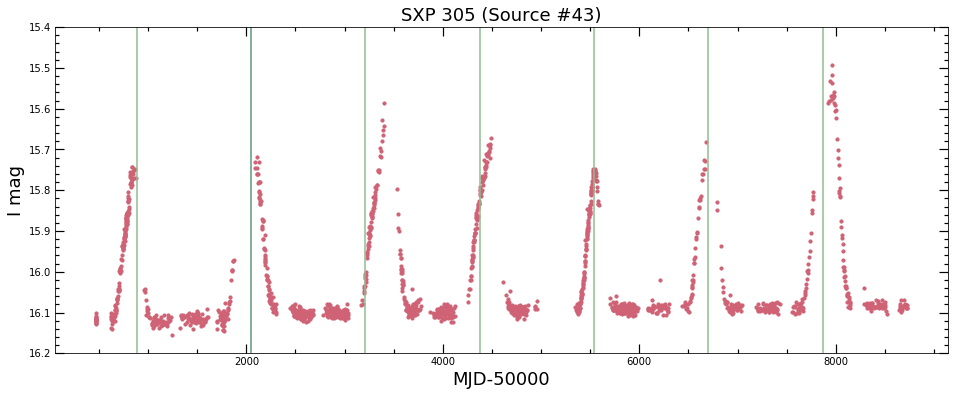

In [2]:
iband = o.getIV(48,cross,stack=True,both=False)
nsrc = src_dict[48]
name = name_dict[48]
plt.figure(figsize=(16,6))
plt.scatter(iband['MJD-50000'],iband['I mag'],color=pink,s=10)
plt.ylim(16.2,15.4)
plt.axvline(2050)
for i in range(-1,6):
    plt.axvline(2050+i*1163,color='darkseagreen',label='1163 days')
plt.xlabel('MJD-50000',fontsize=18)
plt.ylabel('I mag',fontsize=18)
plt.title(f'{name} (Source #{nsrc})',fontsize=18)
# plt.savefig('SuperorbitalPeriodicityMar23/src43_48_established1163.pdf',bbox_inches='tight')

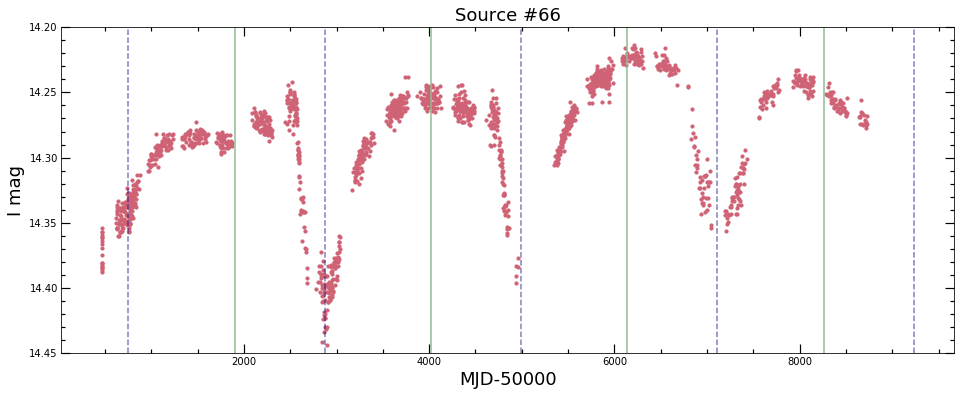

In [16]:
iband = o.getIV(73,cross2,mlist=mlist2,stack=True,both=False)
nsrc = src_dict[73]
name = name_dict[73]
plt.figure(figsize=(16,6))
plt.scatter(iband['MJD-50000'],iband['I mag'],color=pink,s=10)
plt.ylim(14.45,14.2)

for i in range(4):
    plt.axvline(1900+i*2120,color='darkseagreen',label='1163 days')
    
for i in range(-1,4):
    plt.axvline(2870+i*2120,color='navy',ls='dashed',alpha=0.5,label='1163 days')
plt.xlabel('MJD-50000',fontsize=18)
plt.ylabel('I mag',fontsize=18)
plt.title(f'Source #{nsrc}',fontsize=18)

plt.savefig('SuperorbitalPeriodicityMar23/src66_73_2120days.pdf',bbox_inches='tight')

# Go Through Superorbital Periods Reported in Rajoelimanana et al. 2011
- 19 objects
- (spaced lines), ~periodogram~, phase-folded data

In [3]:
sup = alls[alls['Raj superorbital']>0]
np.array(sup['Raj superorbital']) #can first do periodogram range 300 to 3500 or 4000

array([2800.,  621., 1116.,  397., 1786., 1886., 1515., 1220.,  758.,
       2700.,  492., 1220., 3000., 2000., 2000., 1274., 1886., 3000.,
       2857.])

Text(0.1, 0.5, 'LS Power')

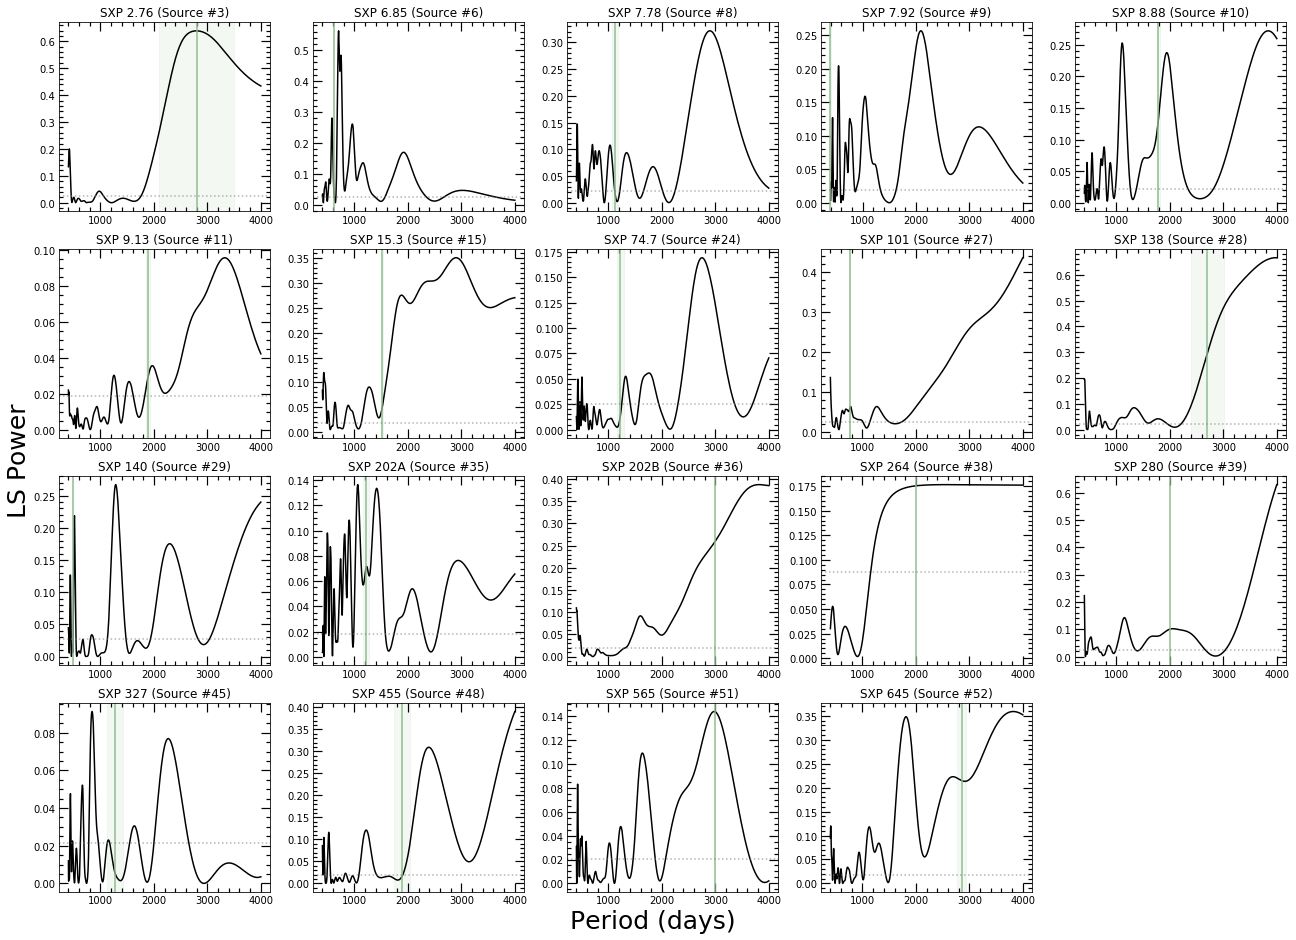

In [4]:
fig = plt.figure(figsize=(22,16))
c = 1
for s in sup['src_n']:
    try: iband = o.getIV(s,cross,stack=True,both=False)
    except: iband = o.getIV(s,cross2,mlist=mlist2,stack=True,both=False)
    #get superorbital period and error
    super_period = float(sup[sup['src_n']==s]['Raj superorbital'])
    super_period_err = float(sup[sup['src_n']==s]['Raj superorbital err'])
    #plot periodogram on added axis
    ax = fig.add_subplot(4,5,c)
    freq,power,bp,false_alarm_level = o.periodogram(iband,minp=400,maxp=4000,more=True,plot=False,fal=0.001)
    ax.plot(1/freq,power,color='black')
    #add shading when there's an error
    if not np.isnan(super_period_err): ax.axvspan(super_period-super_period_err,super_period+super_period_err,alpha=0.1,color='darkseagreen')
    ax.axvline(super_period,color='darkseagreen')
    ax.axhline(false_alarm_level,color='grey',alpha=0.6,ls='dotted')
    nsrc = src_dict[s]
    name = name_dict[s]
    if len(str(name))>3: ax.set_title(f'{name} (Source #{nsrc})')
    else:ax.set_title(f'Source #{nsrc}')
    c+=1
#add shared axes labels
fig.text(0.5, 0.1, 'Period (days)', ha='center', va='center',fontsize=25)
fig.text(0.1, 0.5, 'LS Power', ha='center', va='center', rotation='vertical',fontsize=25)
# plt.savefig('SuperorbitalPeriodicityMar23/Rajoelimanana_periodograms.pdf',bbox_inches='tight')

Text(0.1, 0.5, 'I mag')

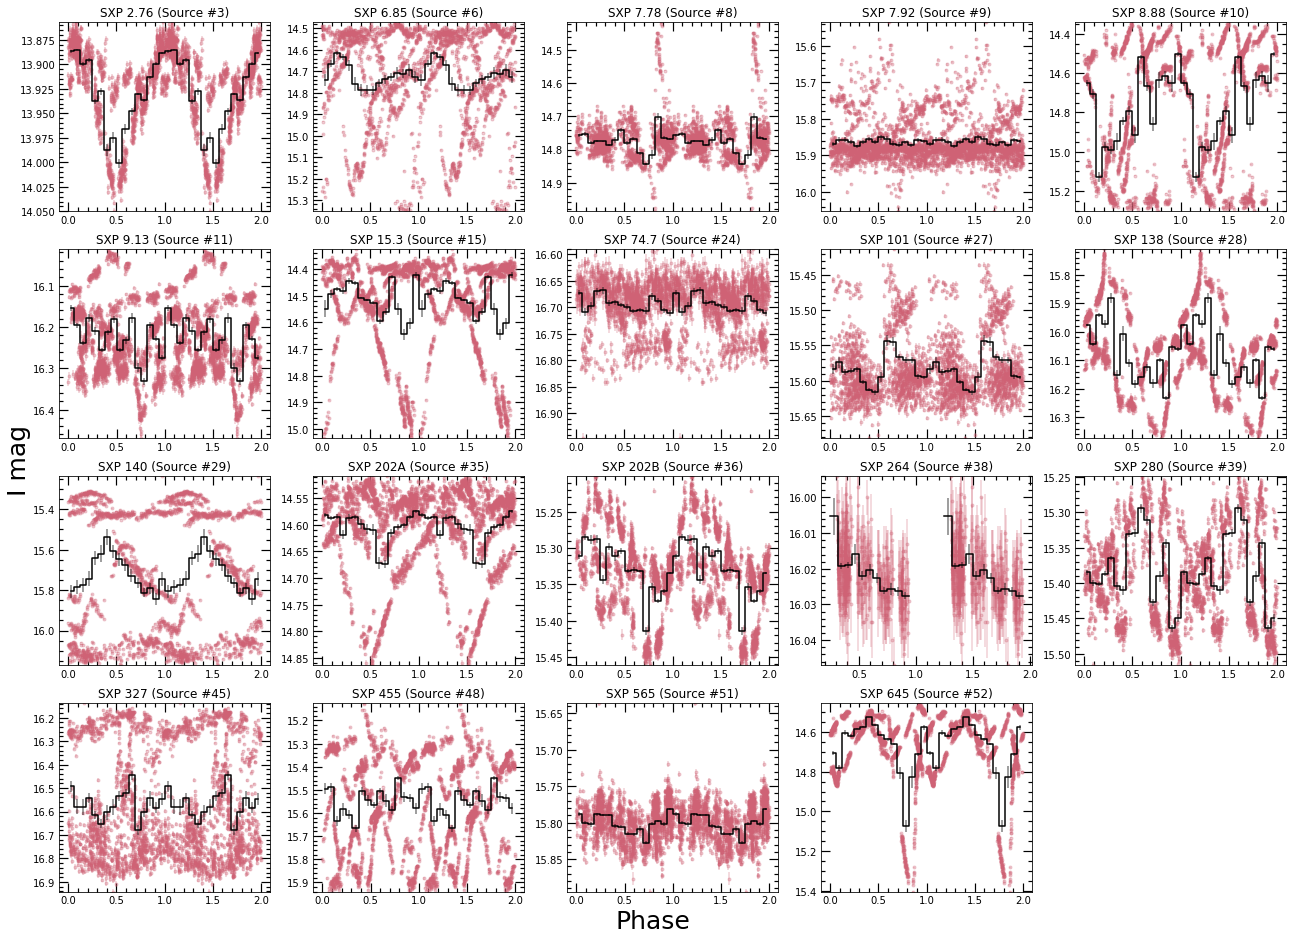

In [5]:
#light curve and phase-folded data with Rajoelimanana et al. 2011 established periods
fig = plt.figure(figsize=(22,16))
c = 1
for s in sup['src_n']:
    try: iband = o.getIV(s,cross,stack=True,both=False)
    except: iband = o.getIV(s,cross2,mlist=mlist2,stack=True,both=False)
    #get superorbital period and error
    super_period = float(sup[sup['src_n']==s]['Raj superorbital'])
    super_period_err = float(sup[sup['src_n']==s]['Raj superorbital err'])
    #plot periodogram on added axis
    ax = fig.add_subplot(4,5,c)
    mid,avg,std = o.meanphase(iband,super_period,pbins=16,det=False,double=True,stdev=True,sterr=True,divide=True)
    ax.step(mid,avg,where='mid',color='black',label=f'{super_period:.2f}',zorder=3)
    ax.errorbar(mid,avg,yerr=std,color='black',marker='',linestyle='none',alpha=0.5,zorder=4)
    maxa,mina = np.nanmax(avg)+std[np.nanargmax(avg)],np.nanmin(avg)-std[np.nanargmin(avg)]
    #plot point as well
    ax.errorbar((iband['MJD-50000']%super_period)/super_period,iband['I mag'],yerr=iband['I mag err'],color=pink,alpha=0.3,ls='none',marker='o',markersize=3,zorder=2)
    ax.errorbar(1+(iband['MJD-50000']%super_period)/super_period,iband['I mag'],yerr=iband['I mag err'],color=pink,alpha=0.3,ls='none',marker='o',markersize=3,zorder=2)
    ax.set_ylim(np.max(iband['I mag']),np.min(iband['I mag']))
    nsrc = src_dict[s]
    name = name_dict[s]
    if len(str(name))>3: ax.set_title(f'{name} (Source #{nsrc})')
    else:ax.set_title(f'Source #{nsrc}')
    c+=1
#add shared axes labels
fig.text(0.5, 0.1, 'Phase', ha='center', va='center',fontsize=25)
fig.text(0.1, 0.5, 'I mag', ha='center', va='center', rotation='vertical',fontsize=25)
# plt.savefig('SuperorbitalPeriodicityMar23/Rajoelimanana_folds.pdf',bbox_inches='tight')



In [6]:
def space_lines(index,use_period=0,first_peak=2500,iterations=7,save=''):
    row = sup.iloc[index]
    s = row['src_n']
    nsrc = src_dict[s]
    name = name_dict[s]
    if len(str(name))>3: title = f'{name} (Source #{nsrc})'
    else: title = f'Source #{nsrc}'
    period = row['Raj superorbital']
    period_err = row['Raj superorbital err']
    if not np.isnan(period_err):print(f'{period}+/-{period_err} days')
    else: print(f'{period} days')

    try: iband = o.getIV(s,cross,stack=True,both=False)
    except: iband = o.getIV(s,cross2,mlist=mlist2,stack=True,both=False)
    
    plt.figure(figsize=(10,4))
    plt.scatter(iband['MJD-50000'],iband['I mag'],color=pink,s=3)
    plt.ylim(np.max(iband['I mag'])+0.02,np.min(iband['I mag'])-0.01)
    plt.title(title,fontsize=14)
    
    if use_period==0: super_period = period
    else: super_period = use_period
    plt.axvline(first_peak,color='darkseagreen',label=f'{super_period}d')

    for i in range(iterations):
        plt.axvline(first_peak+i*super_period,color='darkseagreen')
    plt.legend()
    plt.xlabel('MJD-50000',fontsize=14)
    plt.ylabel('I mag',fontsize=14)
    
    if len(save)>0:plt.savefig(save,bbox_inches='tight')
    plt.show()

2800.0+/-700.0 days


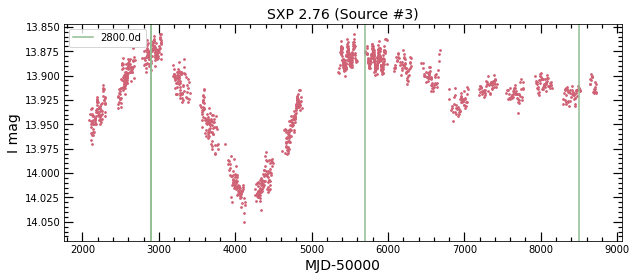

621.0+/-4.0 days


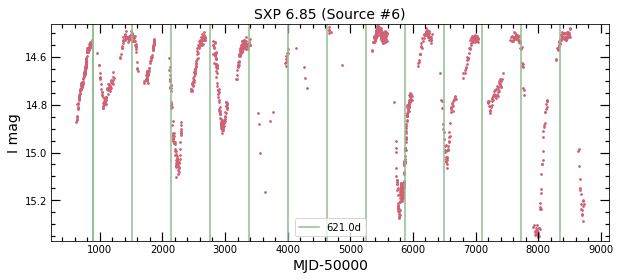

1116.0+/-56.0 days


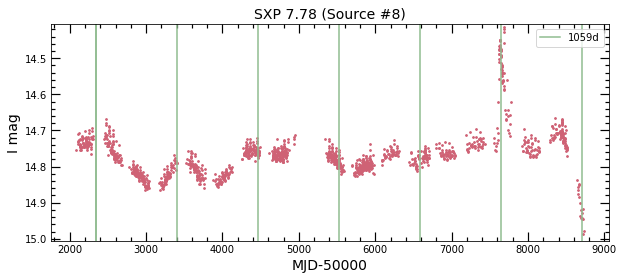

397.0+/-2.0 days


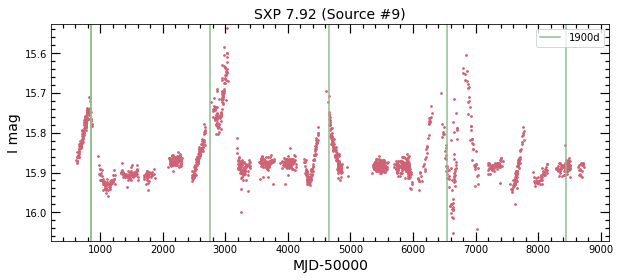

1786.0+/-32.0 days


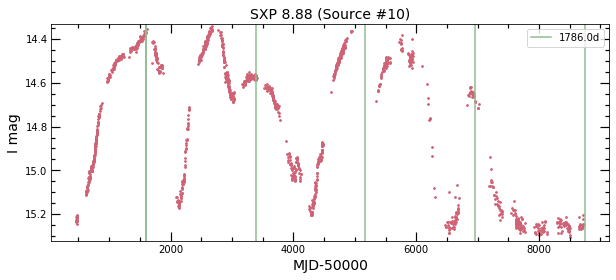

1886.0+/-35.0 days


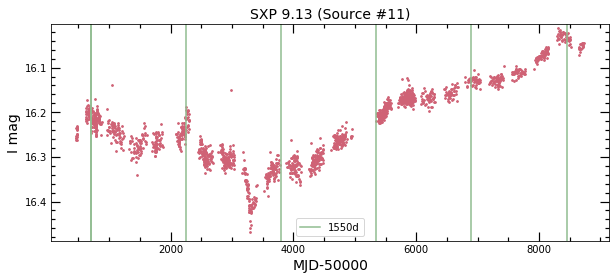

1515.0+/-23.0 days


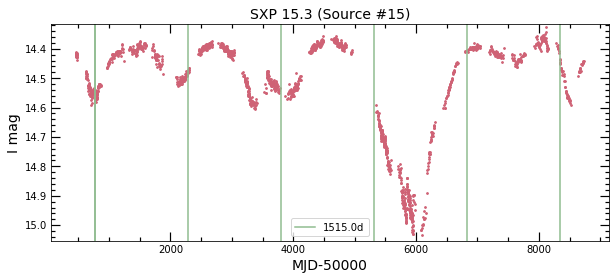

1220.0+/-64.0 days


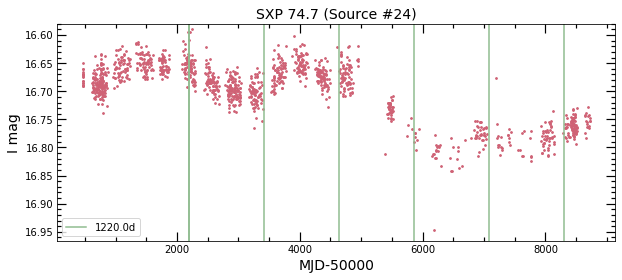

758.0+/-6.0 days


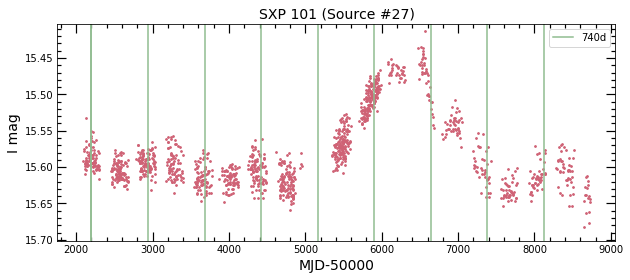

2700.0+/-304.0 days


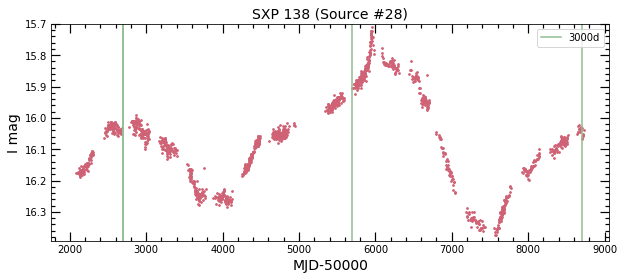

492.0+/-2.4 days


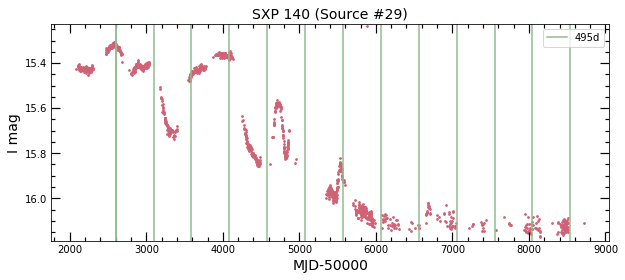

1220.0+/-61.0 days


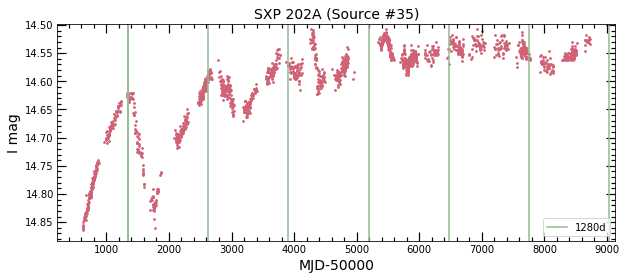

3000.0 days


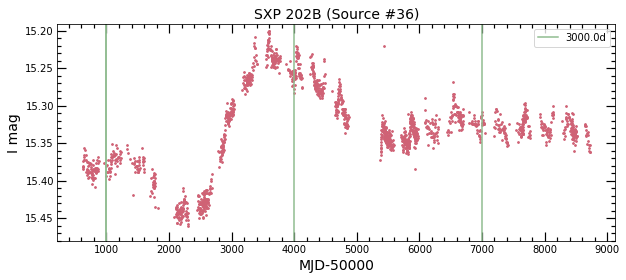

2000.0 days


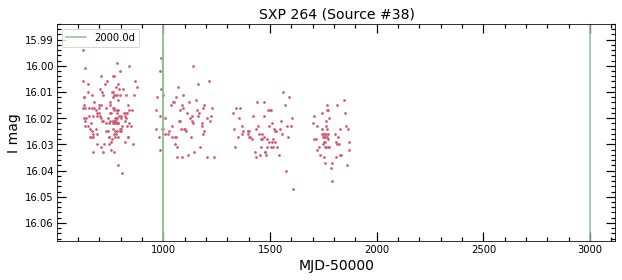

2000.0 days


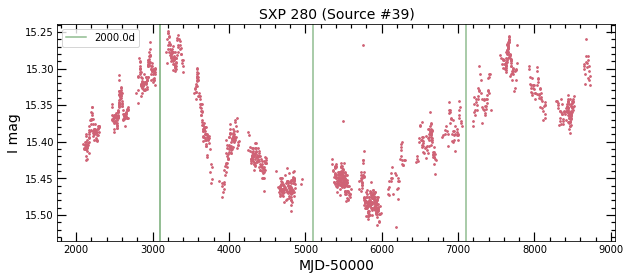

1274.0+/-143.0 days


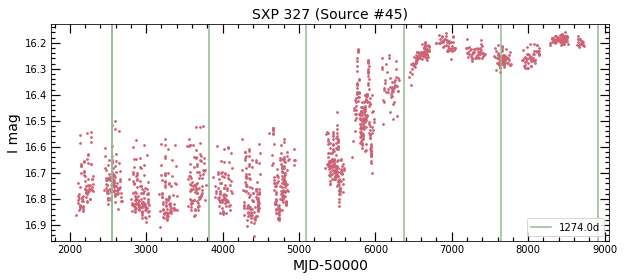

1886.0+/-145.0 days


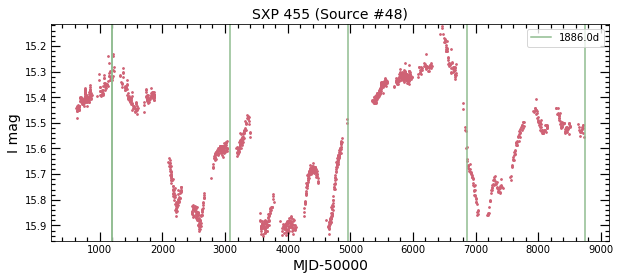

3000.0 days


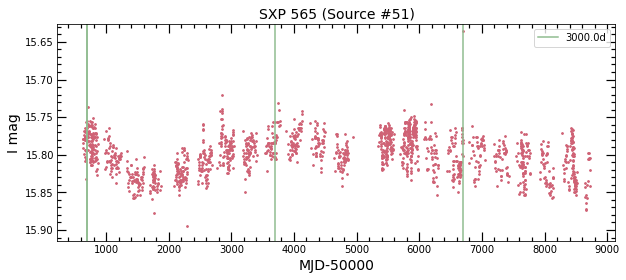

2857.0+/-81.0 days


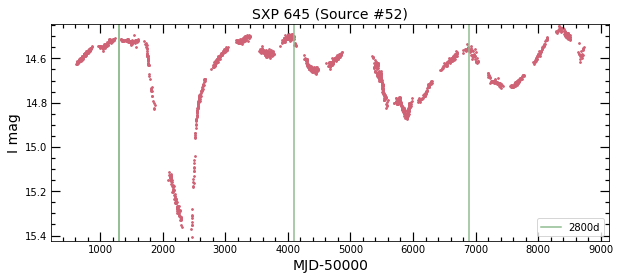

In [7]:
space_lines(0,first_peak=2900,use_period=0,iterations=3)
space_lines(1,first_peak=900,use_period=0,iterations=13)
space_lines(2,first_peak=2350,use_period=1115-56)
#notice I used a very different period than the suggested
space_lines(3,first_peak=850,use_period=1900,iterations=5)
space_lines(4,first_peak=1600,use_period=0,iterations=5)
space_lines(5,first_peak=700,use_period=1550,iterations=6)
space_lines(6,first_peak=775,use_period=0,iterations=6)
space_lines(7,first_peak=2200,use_period=0,iterations=6) #not sure where this should start
space_lines(8,first_peak=2200,use_period=740,iterations=9) #not sure where this should start
space_lines(9,first_peak=2700,use_period=3000,iterations=3) 
space_lines(10,first_peak=2600,use_period=495,iterations=13) 
space_lines(11,first_peak=1350,use_period=1280,iterations=7) 
space_lines(12,first_peak=1000,use_period=0,iterations=3) 
space_lines(13,first_peak=1000,use_period=0,iterations=2) #??
space_lines(14,first_peak=3100,use_period=0,iterations=3) #approximate anyway
space_lines(15,first_peak=2550,use_period=0,iterations=6)
space_lines(16,first_peak=1200,use_period=0,iterations=5)
space_lines(17,first_peak=700,use_period=0,iterations=3)
space_lines(18,first_peak=1300,use_period=2800,iterations=3)

### SXP 6.85 Figure

In [8]:
summ[summ['name']=='SXP 6.85']

,src_n,ra_deg,dec_deg,spin period,perr,X-ray period,est. period,Coe est. period,Coe eccentricity,Coe eccentricity err,...,Coe range,near Coe skew,near Coe kurtosis,near Coe range,2-200d skew,2-200d kurtosis,2-200d range,X-ray skew,X-ray kurtosis,X-ray range
6,7,15.722455,-72.74299,6.85,0.5,21.9,21.9,22.0,0.26,0.03,...,0.005679,0.091402,-1.315675,0.009469,-0.540307,-1.07437,0.021213,-0.007497,-0.630636,0.007322


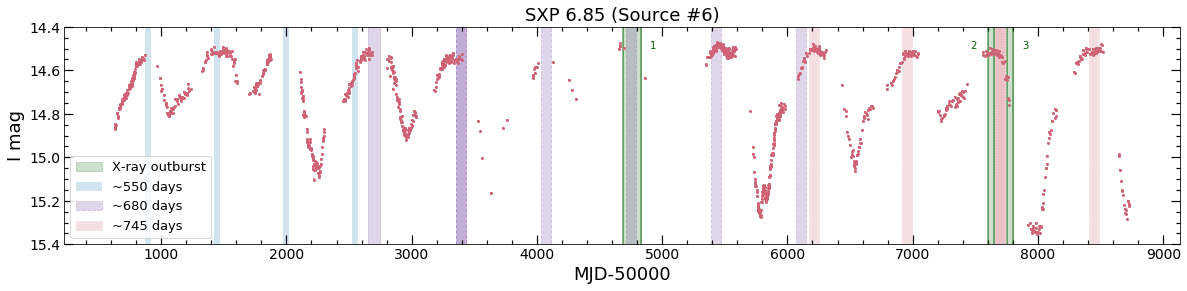

In [9]:
src = 7
nsrc = src_dict[src]
name = name_dict[src]
iband = o.getIV(src,cross,stack=True,both=False)

plt.figure(figsize=(20,4))
plt.errorbar(iband['MJD-50000'],iband['I mag'],yerr=iband['I mag err'],color=pink,markersize=2,marker='o',ls='None')

plt.ylim(15.4,14.4)

plt.axvspan(7598,7598+50,alpha=0.2,color='darkgreen',label='X-ray outburst')
plt.axvline(7598,alpha=0.6,color='darkgreen')
plt.axvline(7598+50,alpha=0.6,color='darkgreen')


plt.axvspan(7750,7801,alpha=0.2,color='darkgreen')
plt.axvline(7750,alpha=0.6,color='darkgreen')
plt.axvline(7801,alpha=0.6,color='darkgreen')

plt.axvspan(4688,4830,color='darkgreen',alpha=0.2)
plt.axvline(4688,color='darkgreen',alpha=0.6)
plt.axvline(4830,color='darkgreen',alpha=0.6)

#530 was best for OII
plt.axvspan(870,920,alpha=0.2,label='~550 days')
plt.axvspan(870+550,920+550,alpha=0.2)
plt.axvspan(870+550*2,920+550*2,alpha=0.2)
plt.axvspan(870+550*3,920+550*3,alpha=0.2)

#new epoch -- and notice it's after that deep dip
plt.axvspan(2650,2750,alpha=0.2,color=purple)
#only 640 days later although previous flare was 680-730 from one before
plt.axvspan(2670+680,2750+680,alpha=0.4,color=purple,ls='dashed')
plt.axvspan(2670+680*2,2750+680*2,alpha=0.2,color=purple,label='~680 days',ls='dashed')
plt.axvspan(2670+680*3,2750+680*3,alpha=0.2,color=purple,ls='dashed')
plt.axvspan(2670+680*4,2750+680*4,alpha=0.2,color=purple,ls='dashed')
plt.axvspan(2670+680*5,2750+680*5,alpha=0.2,color=purple,ls='dashed')

#new epoch
plt.axvspan(6170,6250,alpha=0.2,color=pink,ls='dotted')
plt.axvspan(6170+745,6250+745,alpha=0.2,color=pink,label='~745 days',ls='dotted')
plt.axvspan(6170+745*2,6250+745*2,alpha=0.4,color=pink,ls='dotted')
plt.axvspan(6170+745*3,6250+745*3,alpha=0.2,color=pink,ls='dotted')
plt.text(7801+70,14.5,'3',color='darkgreen')
plt.text(7598-140,14.5,'2',color='darkgreen')
plt.text(4900,14.5,'1',color='darkgreen')

plt.legend(fontsize=13)

plt.ylabel('I mag',fontsize=18)
plt.xlabel('MJD-50000',fontsize=18)
plt.title(f'{name} (Source #{nsrc})',fontsize=18)

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

plt.savefig(f'SuperorbitalPeriodicityMar23/src{nsrc}_{src}_{name}_epochs.pdf',bbox_inches='tight')


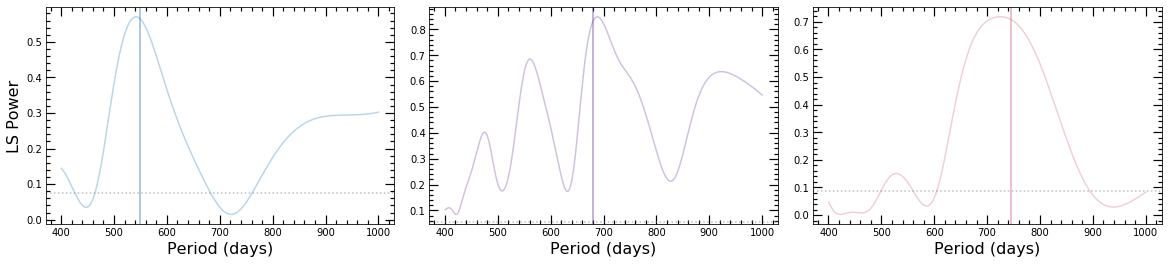

Text(0.5, 0, 'Period (days)')

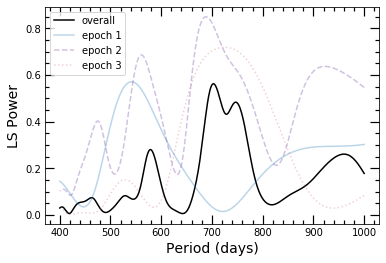

In [10]:
#periodograms for corresponding times
epoch1 = [iband['MJD-50000'][0],2500]
epoch2 = [2500,6000]
epoch3 = [6000,iband['MJD-50000'][-1]]

fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,4))
plt.subplots_adjust(wspace=0.1)
ax1.set_ylabel('LS Power',fontsize=16)
for i in (ax1,ax2,ax3): i.set_xlabel('Period (days)',fontsize=16)
    
itemp = iband[iband['MJD-50000']>=epoch1[0]]
itemp = itemp[itemp['MJD-50000']<=epoch1[1]]
freq1,power1,bp,false_alarm_level = o.periodogram(itemp,minp=400,maxp=1000,det=False,more=True,plot=False,fal=0.001)
ax1.plot(1/freq1,power1,alpha=0.3)
ax1.axhline(false_alarm_level,color='grey',alpha=0.5,ls='dotted')
ax1.axvline(550,alpha=0.5)

itemp = iband[iband['MJD-50000']>=epoch2[0]]
itemp = itemp[itemp['MJD-50000']<=epoch2[1]]
freq2,power2,bp,false_alarm_level = o.periodogram(itemp,minp=400,maxp=1000,det=False,more=True,plot=False,fal=0.001)
ax2.plot(1/freq2,power2,alpha=0.3,color=purple)
ax2.axhline(false_alarm_level,color='grey',alpha=0.5,ls='dotted')
ax2.axvline(680,alpha=0.5,color=purple)

itemp = iband[iband['MJD-50000']>=epoch3[0]]
itemp = itemp[itemp['MJD-50000']<=epoch3[1]]
freq3,power3,bp,false_alarm_level = o.periodogram(itemp,minp=400,maxp=1000,det=False,more=True,plot=False,fal=0.001)
ax3.plot(1/freq3,power3,alpha=0.3,color=pink)
ax3.axhline(false_alarm_level,color='grey',alpha=0.5,ls='dotted')
ax3.axvline(745,alpha=0.5,color=pink)

plt.show()

#periodograms on one plot
freq,power,bp,false_alarm_level = o.periodogram(iband,minp=400,maxp=1000,det=False,more=True,plot=False,fal=0.001)
plt.plot(1/freq,power,color='black',label='overall')
plt.plot(1/freq1,power1,alpha=0.3,label='epoch 1')
plt.plot(1/freq2,power2,alpha=0.3,color=purple,ls='dashed',label='epoch 2')
plt.plot(1/freq3,power3,alpha=0.3,color=pink,ls='dotted',label='epoch 3')
plt.legend()
plt.ylabel('LS Power',fontsize=14)
plt.xlabel('Period (days)',fontsize=14)

#### if there's interest, put these two figures together and be more exact e.g., about epoch values (exact best period, choose epoch cutoffs carefully, etc.)